# Run Galfit on COSMOS galaxies
- 10/27/2020: Updated to use galfit_helpers.py module

### Load modules

In [1]:
from __future__ import division
import sys
sys.path.insert(0,'/data/emiln/XLSSC122_GalPops/Analysis/Modules')
from GalfitPyWrap import galfitwrap as gf
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import glob
from scipy import ndimage
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.io import fits, ascii
from astropy.table import Table, hstack, join
import pickle
import fnmatch
import multiprocessing as mp
%matplotlib inline
%load_ext autoreload
%autoreload 2

/data/emiln/miniconda2/lib/python2.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
import galfit_helpers as gfh

### Load COSMOS galaxy catalog

In [3]:
COSMOS_cat_root = '/data/emiln/XLSSC122_GalPops/Data/Products/COSMOS/catalogs/'
COSMOS_cat_filename = COSMOS_cat_root+'cos_df_all_merged.csv'
full_df = gfh.load_COSMOS_galaxy_catalog(COSMOS_cat_filename,mag='F125W_Kron',magthresh=30, overwrite=False, verbose=True)
filtered_df = gfh.load_COSMOS_galaxy_catalog(COSMOS_cat_filename,magthresh=24, mag='F125W_Kron',overwrite=False, verbose=True)


Checking if catalog exists at /data/emiln/XLSSC122_GalPops/Data/COSMOS/Products/catalogs/magthresh30.csv
Catalog already exists, returning DataFrame
Checking if catalog exists at /data/emiln/XLSSC122_GalPops/Data/COSMOS/Products/catalogs/magthresh24.csv
Catalog already exists, returning DataFrame
/data/emiln/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (399) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
z2_filtered_df = gfh.load_COSMOS_galaxy_catalog(COSMOS_cat_filename,magthresh=24, z=1.98,z_thresh=0.1,overwrite=False,verbose=True) 

Checking if catalog exists at /data/emiln/XLSSC122_GalPops/Data/COSMOS/Products/catalogs/magthresh24_z1.98_zthresh0.1.csv
Catalog already exists, returning DataFrame


In [23]:
print len(z2_filtered_df)
z2_filtered_df.columns.values

156


array(['ID', 'IAU_designation', 'RA_x', 'DEC_x', 'APCOR', 'CFHT_uS_FLUX',
       'CFHT_uS_FLUXERR', 'CFHT_gS_FLUX', 'CFHT_gS_FLUXERR',
       'CFHT_rS_FLUX', 'CFHT_rS_FLUXERR', 'CFHT_iS_FLUX',
       'CFHT_iS_FLUXERR', 'CFHT_zS_FLUX', 'CFHT_zS_FLUXERR',
       'Subaru_B_FLUX', 'Subaru_B_FLUXERR', 'Subaru_gp_FLUX',
       'Subaru_gp_FLUXERR', 'Subaru_V_FLUX', 'Subaru_V_FLUXERR',
       'Subaru_rp_FLUX', 'Subaru_rp_FLUXERR', 'Subaru_ip_FLUX',
       'Subaru_ip_FLUXERR', 'Subaru_zp_FLUX', 'Subaru_zp_FLUXERR',
       'ACS_F606W_FLUX', 'ACS_F606W_FLUXERR', 'ACS_F814W_FLUX',
       'ACS_F814W_FLUXERR', 'WFC3_F125W_FLUX', 'WFC3_F125W_FLUXERR',
       'WFC3_F160W_FLUX', 'WFC3_F160W_FLUXERR', 'UltraVISTA_Y_FLUX',
       'UltraVISTA_Y_FLUXERR', 'UltraVISTA_J_FLUX',
       'UltraVISTA_J_FLUXERR', 'UltraVISTA_H_FLUX',
       'UltraVISTA_H_FLUXERR', 'UltraVISTA_Ks_FLUX',
       'UltraVISTA_Ks_FLUXERR', 'IRAC_Ch1_FLUX', 'IRAC_Ch1_FLUXERR',
       'IRAC_Ch2_FLUX', 'IRAC_Ch2_FLUXERR', 'IRAC_Ch3_FLUX',

### Set Galfit parameters

In [7]:
# fit_df = filtered_df[0:4]
fit_df = z2_filtered_df[0:4]
df_name = 'TEST_modular_galfit'
psf_root = '/data/emiln/XLSSC122_GalPops/Data/Products/COSMOS/PSF/'
psf_file = psf_root+'COSMOS/psfJ.fits' # J = F125W, H=F160W
PSFf = 1 
convbox='40 40'
image_width = 400 # 200 for mag<23 objects, 400 for z2 objects
timeout=2*60
verbose=True
width=10
HLRwidth=10 # Cutout width = 2*HLwidth
PA_INIT = 45
AR_INIT = 0.5
# zp = -21.1 # From header
ZP = 26.2303 # From https://archive.stsci.edu/pub/hlsp/candels/cosmos/cos-tot/v1.0/hlsp_candels_hst_cos-tot_readme_v1.0.pdf
MAG_INIT = 21
fitMagnitude = True
neighbourMagThresh=2
DYNMAG = True
sky='Default'
sky_INIT=0.00001
sigma_file = '/sigma_rms_meanexp_cps.fits'
data_file = '/data_cps.fits'
constraint_file = 'galfit_constr.txt' # Matches van der wel 2012 constraints
# constr_file = 'none'
badmask='none'
save_name = None

In [8]:
params = {
    'fit_df':fit_df, # Dataframe with objects to be fit
    'full_df':full_df, # Unfiltered source catalog used for fitting neighbours
    'width':width, # Fitting region width in pixels
    'HLRwidth':HLRwidth, # Fitting region width in # of HLR
    'sigma_file':sigma_file, # Filename of sigma maps for sources
    'data_file':data_file, # Filename for data cutouts for each source
    'PSF_file':psf_file, # File_name of PSF to be used
    'usePSF':True, # Use PSF in fitting?
    'timeout':timeout, # Max runtime per object in seconds
    'PSFf':PSFf, # Fine sampling factor
    'verbose':verbose, # Verbose mode
    'PA_INIT':PA_INIT, # Initial position angle
    'AR_INIT':AR_INIT, # Initial axis ratio
    'MAG_INIT':MAG_INIT, # Initial magnitude
    'convbox':convbox, # Region to convolve PSF with in pixels (i.e. '100 100')
    'ZP':ZP, # Zeropoint 
    'constraint_file':constraint_file, # Galfit constraint filename
    'image_width':image_width, # Size of data+sigma images being used (200 for COSMOS cutouts)
    'useDYNMAG':DYNMAG, # Initialize magnitudes from catalog?
    'badmask':badmask, # filename for bad pixel mask
    'fitMagnitude':fitMagnitude, # Fit magnitudes?
    'sky':sky, # Sky fitting mode for galfit (i.e. 'default')
    'sky_INIT':sky_INIT, # Initial sky level
    'neighbourMagThresh':neighbourMagThresh, # Additional magnitude threshhold to fit neighbours (i.e. 3 -> only neighbours with mag < source_mag+3 are fit)
    'df_name': df_name, # Descriptive name of catalog being fit
    'save_name':save_name # Filename to save results to, overrides default
}

### Run Galfit

In [16]:
new_df, savename = gfh.run_galfit_parallel(params,**params) # Feeds in unwrapped params as well as a copy to be passed as kwargs to sub functions

Initializing 185 with F125W Kron magnitude: 23.52
ID 185
RA: 150.0730022
DEC: 2.1812181
Initial X: 9997.76290834
Initial Y: 8015.23773933
Cutout X: 400
Cutout Y: 400
Cutout width: 400
Cutoutwidth (pixels) for ID 185 : 96
Cutoutwidth (arcsec) for ID 185 : 5.76
Bounds: [352, 448, 352, 448]
0 NEIGHBOURS FOUND
Adding additional model components for neighbours...
Using PSF
Running galfit from CWD: /data/emiln/XLSSC122_GalPops/Data/Products/COSMOS/galfit_results/185
Initializing 453 with F125W Kron magnitude: 22.36
ID 453
RA: 150.1254026
DEC: 2.185425
Initial X: 6856.01840173
Initial Y: 8267.61598913
Cutout X: 400
Cutout Y: 400
Cutout width: 400
Cutoutwidth (pixels) for ID 453 : 84
Cutoutwidth (arcsec) for ID 453 : 5.04
SAVE_NAME:TEST_modular_galfit_data_cps_sigma_rms_meanexp_cps_w10HLR_psfJ_2min_CONV40_CONSTR_DYNMAG
Bounds: [358, 442, 358, 442]
0 NEIGHBOURS FOUND
Adding additional model components for neighbours...
Using PSF
Running galfit from CWD: /data/emiln/XLSSC122_GalPops/Data/Product

### Validate results

    ID          ra       dec      re      ar       n      mag      sky  \
0  185  150.073002  2.181218  4.1045  0.4733  0.9058  23.2663  0.00056   

     chi2nu  ErrorValue  
0  0.532096           0  


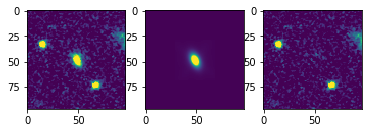

    ID          ra       dec      re      ar      n      mag       sky  \
1  453  150.125403  2.185425  3.3696  0.4411  1.813  22.0147 -0.000856   

     chi2nu  ErrorValue  
1  0.195907           0  


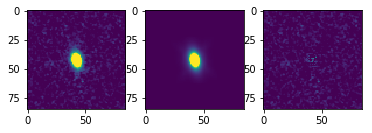

    ID          ra       dec      re      ar       n      mag       sky  \
2  801  150.197511  2.190162  2.5864  0.7202  1.4828  23.2504 -0.000959   

     chi2nu  ErrorValue  
2  0.202377           0  


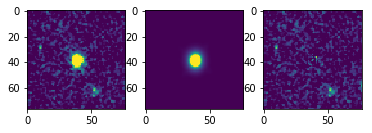

    ID          ra       dec      re      ar       n      mag       sky  \
3  854  150.139466  2.190714  1.4867  0.6486  2.8059  23.0647 -0.000482   

     chi2nu  ErrorValue  
3  0.186977           0  


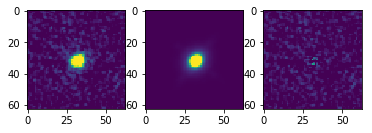

In [19]:
# Plot fits by ID
for ID in fit_df['ID']:
    gfh.plot_by_ID(ID,save_name=savename,survey='COSMOS')

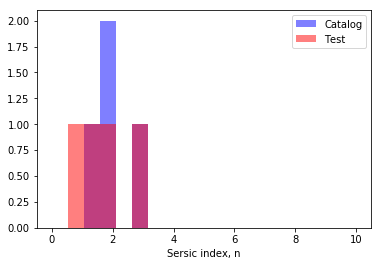

3.0011


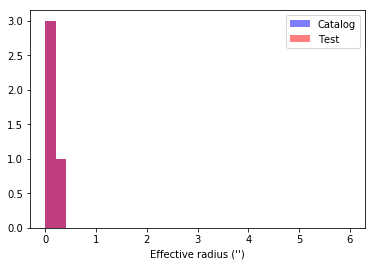

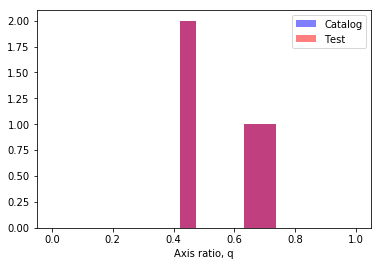

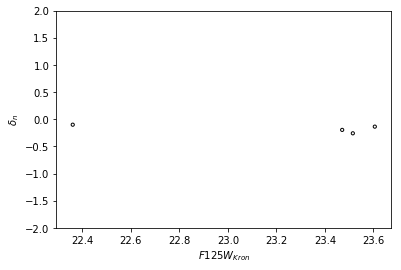

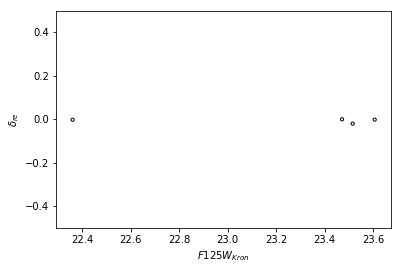

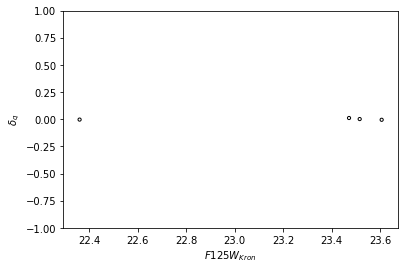

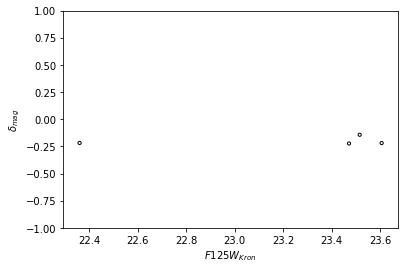

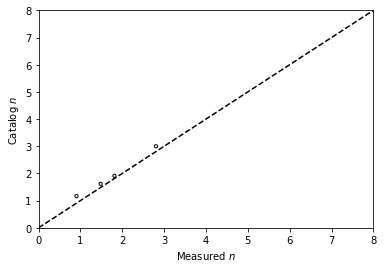

Mean abs dex difference between measured and catalog n: 0.04980086054021918
Median abs dex difference between measured and catalog n: 0.03356552915286526
Mean abs diff between measured and catalog n: 0.17202500000000007
Median abs diff between measured and catalog n: 0.16525000000000023
Mean difference between measured and catalog n: -0.17202500000000007
Median difference between measured and catalog n: -0.16525000000000023
STD of difference between measured and catalog n: 0.06025547174323671
Median offset in delta(n)/n in dex: -0.13195845627792896
Scatter in in delta(n)/n in dex: 0.6700475421261348


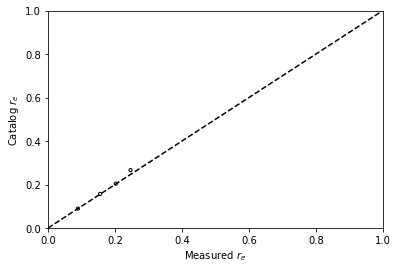

Mean offset between measured and cataloged re (percentage): -2.39
Mean abs offset between measured and cataloged re (percentage): 2.39
Median offset between measured and cataloged re (percentage): -1.0
Median abs offset between measured and cataloged re (percentage): 1.0
Mean abs dex difference between measured and catalog re: 0.010715667357259373
Median abs dex difference between measured and catalog re: 0.0043464432506557515
Mean abs diff between measured and catalog re: 0.005899500000000009
Median abs diff between measured and catalog re: 0.001791000000000001
Mean difference between measured and catalog re: -0.005899500000000009
Median difference between measured and catalog re: -0.001791000000000001


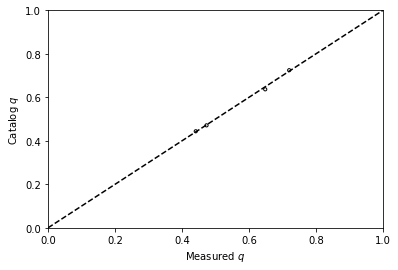

Mean dex difference between measured and catalog q: 0.0038375182551727213
Median dex difference between measured and catalog q: 0.002756577440224728
Mean abs dex diff between measured and catalog n: 0.0038375182551727213
Median abs dex diff between measured and catalog n: 0.002756577440224728
Mean dex difference between measured and catalog q: 0.0010809408149479935
Median dex difference between measured and catalog q: -0.00040843227900527745


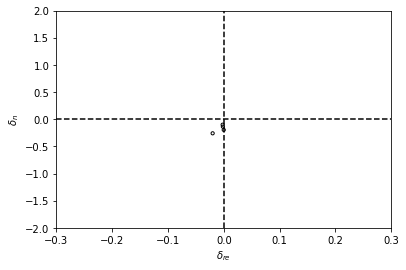

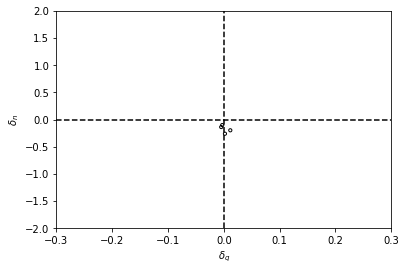

In [26]:
# Compare COSMOS results to published catalog
# cos_df = gfh.load_COSMOS_published_cat()

gfh.compare_COSMOS(savename,fit_df,sky_test=False)